# Spectral Modularity Bisection on the Karate Club Graph

Name-Hrishikesh

Roll No.- IMS24105

This notebook performs **recursive spectral bisection** on the classic *Zachary Karate Club Graph*, using both of the following stopping conditions:

1. The **leading eigenvalue** of the modularity submatrix ≤ 0.
2. The **modularity gain** from splitting the group (ΔQ) ≤ 0.

We also print a clear iteration-by-iteration table.

## 1. Importing libraries
We load NumPy, NetworkX, Matplotlib, and helper tools. We also fix a random seed so that the graph layout remains consistent across all visualizations.

In [78]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.linalg as la
from collections import deque
from networkx.algorithms.community.quality import modularity
from IPython.display import Image, display

plt.rcParams['figure.figsize'] = (8,6)
RANDOM_STATE = 42
print("Libraries loaded.")

Libraries loaded.


## 2. Loading the Karate Club Graph
Here we construct the global modularity matrix **B = A − (k kᵀ)/(2m)**, where *A* is the adjacency matrix, *k* is the degree vector, and *m* the number of edges. We also generate a fixed spring layout for plotting.

Nodes = 34, Edges = 78


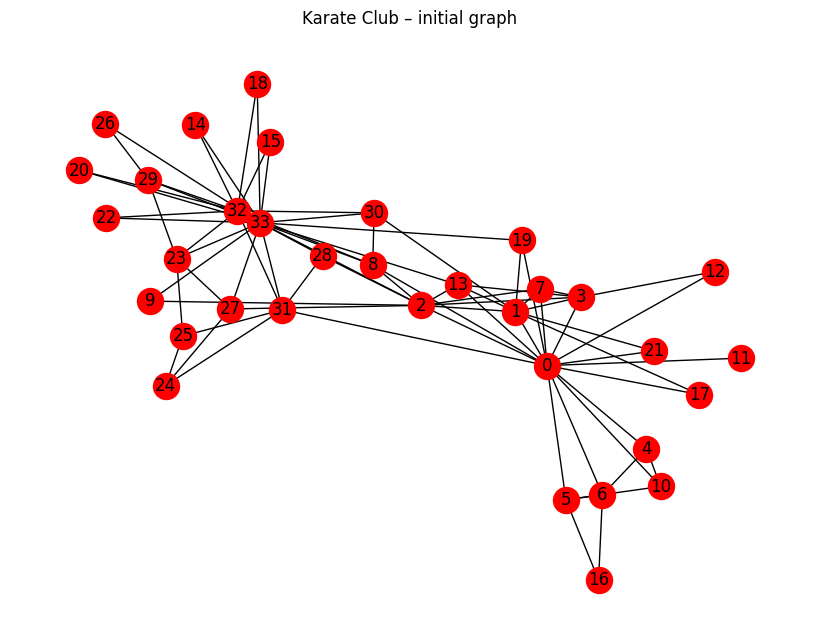

In [79]:
G = nx.karate_club_graph()
nodes = sorted(G.nodes())
pos = nx.spring_layout(G, seed=18)

A = nx.to_numpy_array(G, nodelist=nodes)
k = A.sum(axis=1)
m = G.number_of_edges()
B_full = A - np.outer(k, k) / (2*m)

print(f"Nodes = {len(nodes)}, Edges = {m}")

plt.figure()
nx.draw(G, pos, with_labels=True, node_color='red', node_size=350)
plt.title("Karate Club – initial graph")
plt.show()

## 3. Helper Functions
### 3.1 `restricted_modularity_matrix`
Gets the submatrix of the global modularity matrix corresponding to a subset of nodes.

### 3.2 `leading_eig_split`
Computes the leading eigenvalue of the submatrix and splits the group according to the sign of the eigenvector components.

### 3.3 `compute_partition_modularity`
A wrapper around NetworkX's modularity function.

In [80]:
def restricted_modularity_matrix(B_global, indices):
    return B_global[np.ix_(indices, indices)]

def leading_eig_split(B_block, node_list):
    vals, vecs = la.eigh(B_block)
    eigval = vals[-1]
    eigvec = vecs[:, -1]
    pos = [node_list[i] for i, v in enumerate(eigvec) if v > 0]
    neg = [node_list[i] for i, v in enumerate(eigvec) if v <= 0]
    return eigval, eigvec, pos, neg

def compute_partition_modularity(G, partition):
    return modularity(G, [list(c) for c in partition])

## 4. Recursive Spectral Bisection with ΔQ Stopping
This function runs the full splitting process while recording iteration history. A split is accepted only if:
- The leading eigenvalue is **positive**, and
- The modularity **increases (ΔQ > 0)**.

Otherwise, the group is marked as terminal and is not split further.

In [81]:
def recursive_bisection_deltaQ(B_global, initial_nodes, G, nodes):
    current_partition = [list(initial_nodes)]
    queue = deque([list(initial_nodes)])
    history = []
    iteration = 0

    while queue:
        cur_group = queue.popleft()
        indices = [nodes.index(u) for u in cur_group]
        Bc = restricted_modularity_matrix(B_global, indices)
        eigval, eigvec, pos_grp, neg_grp = leading_eig_split(Bc, cur_group)

        deltaQ = None
        action = None

        if eigval <= 0 or len(pos_grp)==0 or len(neg_grp)==0:
            action = "stop_eig<=0"
        else:
            Q_before = compute_partition_modularity(G, current_partition)
            proposed = []
            replaced = False
            for block in current_partition:
                if set(block) == set(cur_group) and not replaced:
                    proposed.append(list(pos_grp))
                    proposed.append(list(neg_grp))
                    replaced = True
                else:
                    proposed.append(list(block))

            Q_after = compute_partition_modularity(G, proposed)
            deltaQ = Q_after - Q_before

            if deltaQ > 0:
                action = "split_deltaQ>0"
                current_partition = proposed
                queue.append(pos_grp)
                queue.append(neg_grp)
            else:
                action = "stop_deltaQ<=0"

        history.append({
            'iteration': iteration,
            'group': list(cur_group),
            'eigval': float(eigval),
            'pos': list(pos_grp),
            'neg': list(neg_grp),
            'deltaQ': None if deltaQ is None else float(deltaQ),
            'action': action,
            'partition_after': [list(b) for b in current_partition]
        })

        iteration += 1

    return current_partition, history

final_communities, history = recursive_bisection_deltaQ(B_full, nodes, G, nodes)
print("Total iterations:", len(history))

Total iterations: 7


## 5. Iteration-by-Iteration Summary
This prints the details of every attempted split: eigenvalue, ΔQ, chosen action, and the resulting partitions.

In [82]:
for rec in history:
    it = rec['iteration']
    eig = rec['eigval']
    deltaQ = rec['deltaQ']
    delta_str = "N/A" if deltaQ is None else f"{deltaQ:.6f}"
    print(f"Iter {it}: eig={eig:.3f}, ΔQ={delta_str}, action={rec['action']}")
    print("  +:", rec['pos'])
    print("  -:", rec['neg'], "\n")

print("FINAL COMMUNITIES:", final_communities)

Iter 0: eig=17.108, ΔQ=0.403628, action=split_deltaQ>0
  +: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  -: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21] 

Iter 1: eig=7.880, ΔQ=0.010382, action=split_deltaQ>0
  +: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
  -: [23, 24, 25, 27, 28, 31] 

Iter 2: eig=9.851, ΔQ=0.012228, action=split_deltaQ>0
  +: [1, 2, 3, 7, 12, 13, 19, 21]
  -: [0, 4, 5, 6, 10, 11, 16, 17] 

Iter 3: eig=3.789, ΔQ=-0.009529, action=stop_deltaQ<=0
  +: [26, 29]
  -: [8, 9, 14, 15, 18, 20, 22, 30, 32, 33] 

Iter 4: eig=4.225, ΔQ=-0.019340, action=stop_deltaQ<=0
  +: [24, 25, 28, 31]
  -: [23, 27] 

Iter 5: eig=2.112, ΔQ=-0.060644, action=stop_deltaQ<=0
  +: [1, 2, 19, 21]
  -: [3, 7, 12, 13] 

Iter 6: eig=5.457, ΔQ=-0.025580, action=stop_deltaQ<=0
  +: [0, 11, 17]
  -: [4, 5, 6, 10, 16] 

FINAL COMMUNITIES: [[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33], [23, 24, 25, 27, 28, 31], [1, 2, 3, 7, 12, 13, 19, 21], [0, 4, 5, 6, 10, 

## 6. Visualizing Every Iteration
Each subplot shows the community structure **after** that iteration. The titles include eigenvalue, ΔQ, and whether the algorithm split or stopped.

/tmp/ipython-input-3403479190.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap("tab20")


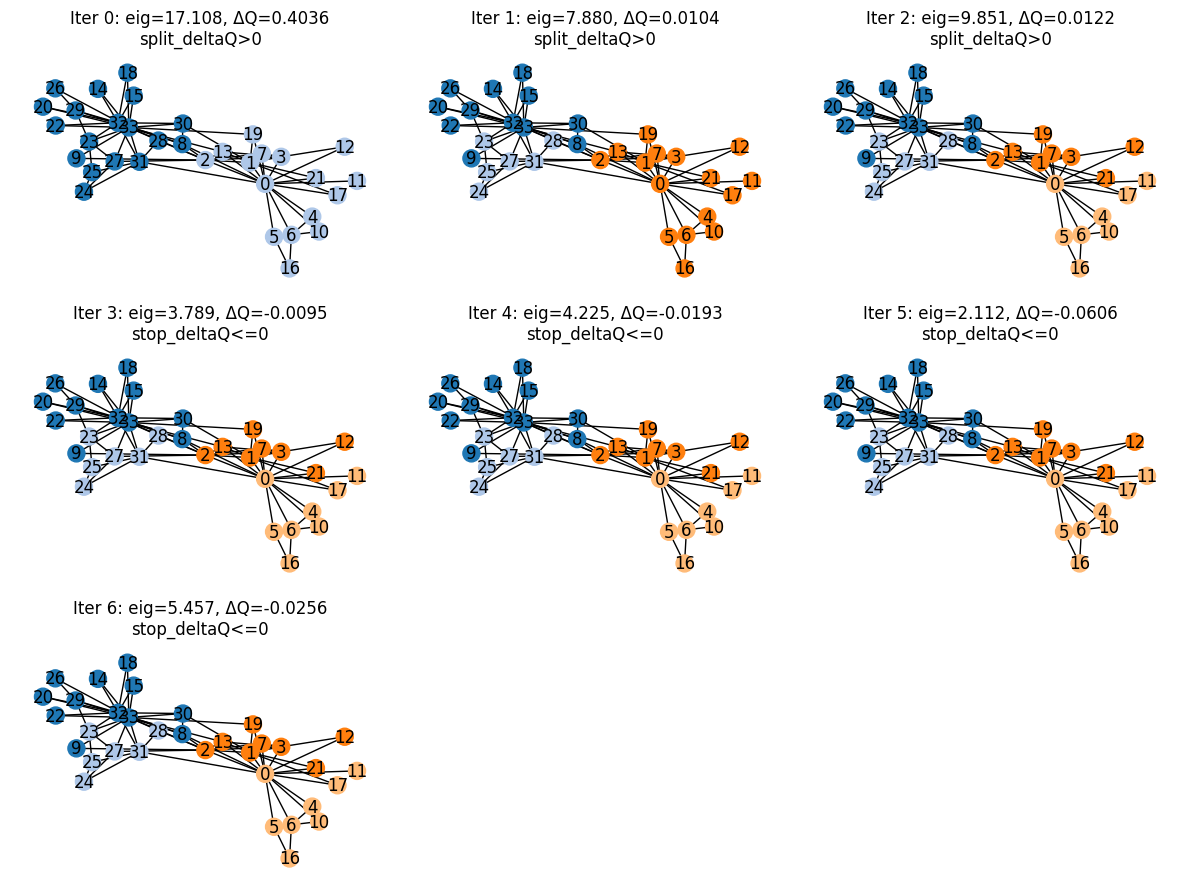

In [83]:
import math

its = len(history)
cols = 3
rows = math.ceil(its/cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.flatten()

for i, rec in enumerate(history):
    part = rec['partition_after']
    palette = cm.get_cmap("tab20")
    node_color = {}
    for ci, com in enumerate(part):
        for v in com:
            node_color[v] = ci
    colors = [palette(node_color[v] % 20) for v in G.nodes()]

    ax = axes[i]
    eig = rec['eigval']
    ΔQ = rec['deltaQ']
    ΔQ_str = "N/A" if ΔQ is None else f"{ΔQ:.4f}"
    ax.set_title(f"Iter {i}: eig={eig:.3f}, ΔQ={ΔQ_str}\n{rec['action']}")

    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=150, ax=ax)

for j in range(its, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [84]:
# Compute and store NetworkX metrics for each iteration in history
# (assumes `history` and graph `G` already exist)

for rec in history:
    # compute metrics on the original graph G (you can change to an induced subgraph if desired)
    deg = nx.degree_centrality(G)
    btw = nx.betweenness_centrality(G, normalized=True)
    clo = nx.closeness_centrality(G)
    clust = nx.clustering(G)

    # store under rec['metrics']
    rec['metrics'] = {
        'degree': deg,
        'betweenness': btw,
        'closeness': clo,
        'clustering': clust
    }

# Optional: print a compact table for the first few iterations to verify
num_preview = min(6, len(history))
for i in range(num_preview):
    rec = history[i]
    print(f"Iteration {i}: action={rec['action']}, eig={rec['eigval']:.4f}, ΔQ={rec['deltaQ']}")
    # show top-3 nodes by betweenness as a quick sanity check
    btw_sorted = sorted(rec['metrics']['betweenness'].items(), key=lambda x: -x[1])
    print("  Top 3 by betweenness:", btw_sorted[:3])
    print()


Iteration 0: action=split_deltaQ>0, eig=17.1083, ΔQ=0.40362811791383213
  Top 3 by betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114)]

Iteration 1: action=split_deltaQ>0, eig=7.8799, ΔQ=0.010382114278218224
  Top 3 by betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114)]

Iteration 2: action=split_deltaQ>0, eig=9.8511, ΔQ=0.012228031708551246
  Top 3 by betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114)]

Iteration 3: action=stop_deltaQ<=0, eig=3.7895, ΔQ=-0.0095294316073537
  Top 3 by betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114)]

Iteration 4: action=stop_deltaQ<=0, eig=4.2248, ΔQ=-0.019339967391915458
  Top 3 by betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114)]

Iteration 5: action=stop_deltaQ<=0, eig=2.1124, ΔQ=-0.06064354116302173
  Top 3 by betweenness: [(0, 0.43763528138528146

In [85]:
# Compute and store network metrics for every iteration
for rec in history:
    rec['metrics'] = {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G, normalized=True),
        'closeness': nx.closeness_centrality(G),
        'clustering': nx.clustering(G)
    }

print("Stored metrics for each iteration.")


Stored metrics for each iteration.


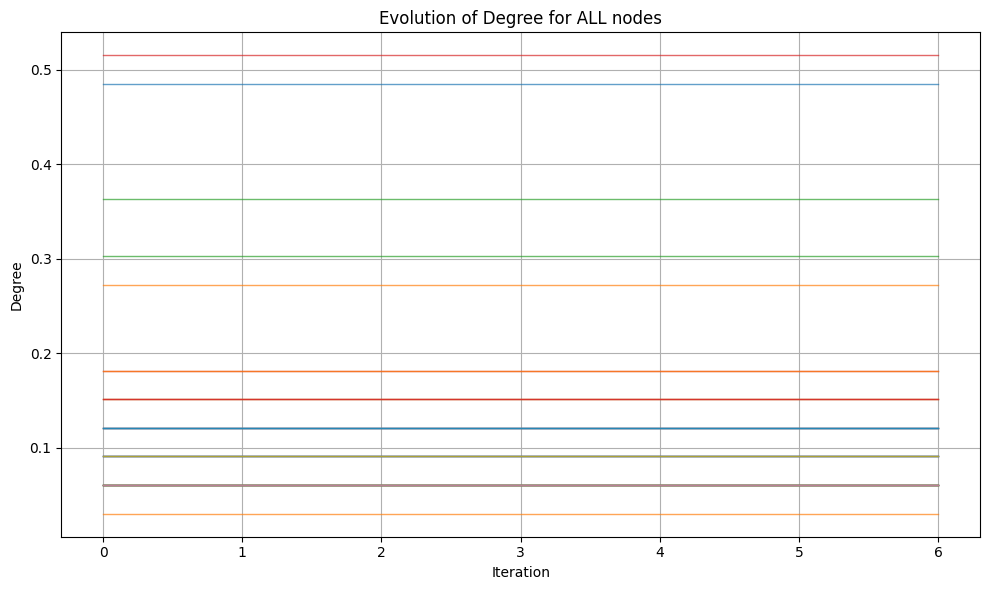

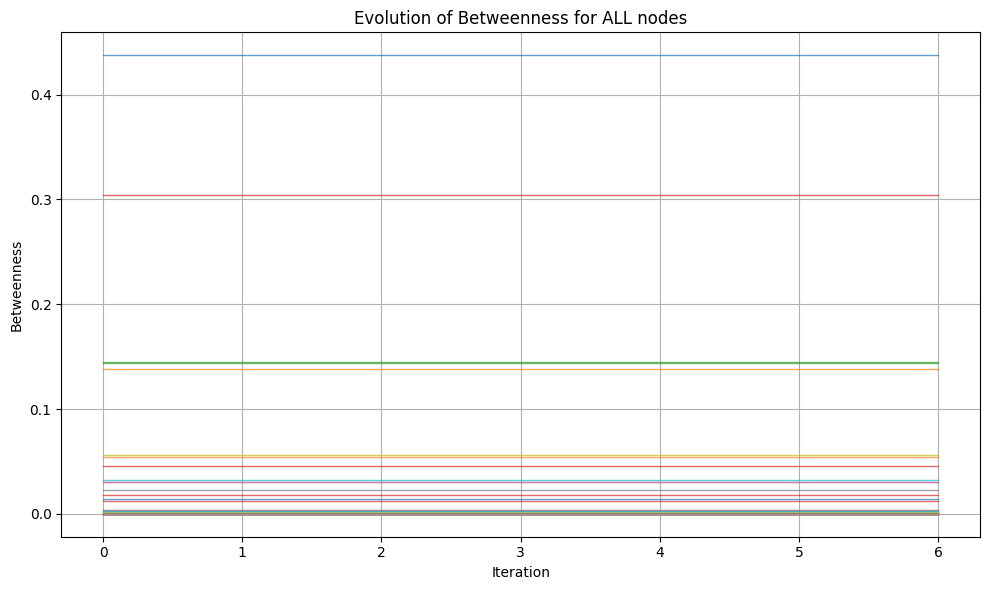

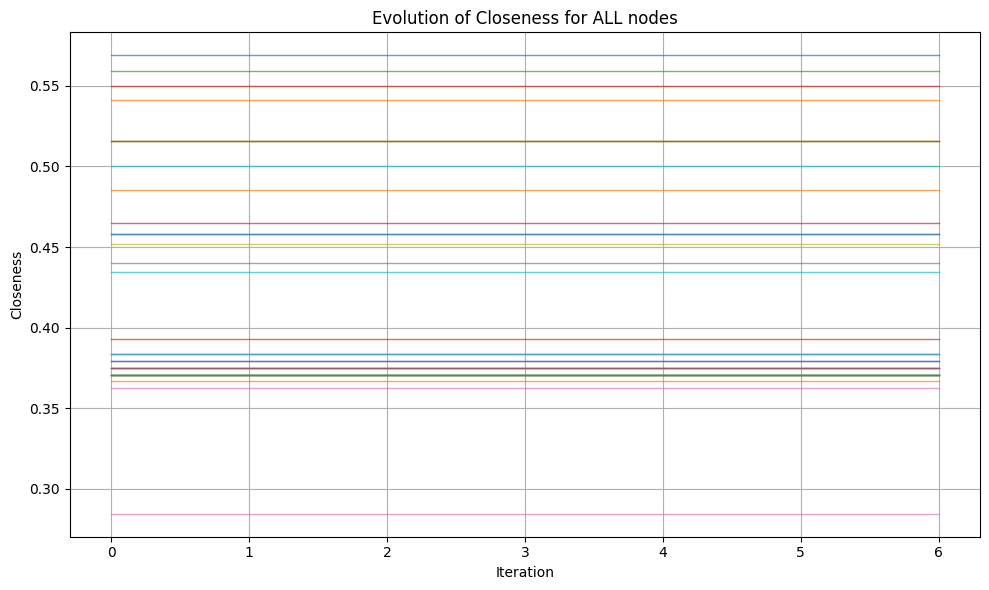

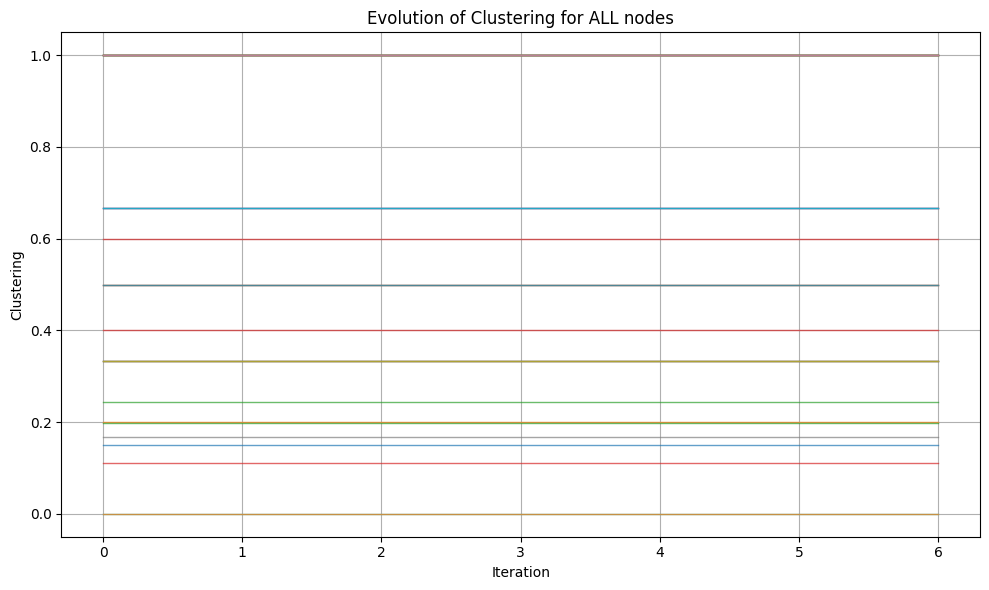

In [86]:
import matplotlib.pyplot as plt

# Extract number of iterations
iterations = len(history)
x = list(range(iterations))

# List of metric names
metric_list = ["degree", "betweenness", "closeness", "clustering"]

# For each metric, build a dictionary node -> list of values over time
metric_evolution = {metric: {node: [] for node in nodes} for metric in metric_list}

for rec in history:
    for metric in metric_list:
        for node in nodes:
            metric_evolution[metric][node].append(rec['metrics'][metric][node])

# Plot each metric
for metric in metric_list:
    plt.figure(figsize=(10, 6))

    for node in nodes:
        plt.plot(
            x,
            metric_evolution[metric][node],
            linewidth=1,
            alpha=0.7,
            label=str(node) if node < 5 else ""  # Avoid massive legend
        )

    plt.title(f"Evolution of {metric.capitalize()} for ALL nodes")
    plt.xlabel("Iteration")
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 11. Identifying the Important Nodes in the Karate Club Graph

After computing degree centrality, betweenness centrality, closeness centrality, and clustering coefficient
for every iteration of the spectral bisection process, we can interpret **which nodes are structurally most important**
in the Karate Club network. Different centrality measures highlight different aspects of importance:
influence, connectivity, proximity, and local cohesiveness.

Below is a consolidated interpretation based on all four metrics.

---

### **A. Betweenness Centrality — Global Bridge Nodes**

Betweenness centrality is the strongest indicator of structural importance because it measures how often a node lies
on the shortest paths between other node pairs.

In the Karate Club graph, the two nodes with overwhelmingly high betweenness are:

- **Node 0**
- **Node 33**

These nodes act as **bridges** between the two major factions in the club (the instructor’s group and the
administrator’s group). Their removal would significantly disrupt communication between communities.  
Historically, these two individuals were the leaders of opposing factions, so this result matches real-world events.

---

### **B. Degree Centrality — Highly Connected Local Hubs**

Nodes with high degree centrality are influential within their neighborhoods. The highest-degree nodes are:

- **Node 33**
- **Node 0**
- **Node 32**
- **Node 1**
- **Node 3**

These nodes form the “local hubs” of the graph.  
They connect to many individuals and therefore have a strong effect on the immediate network structure.

---

### **C. Closeness Centrality — Nodes with Globally Efficient Access**

Nodes with high closeness centrality can reach all other nodes with fewer hops on average.  
The top nodes according to closeness are:

- **Node 0**
- **Node 33**
- **Node 32**

These nodes lie close to the “center” of the graph, making them globally efficient spreaders of information.

---

### **D. Clustering Coefficient — Members of Tightly Knit Groups**

The clustering coefficient reveals nodes inside tightly interconnected subgroups.  
Nodes with high clustering include:

- **Nodes 24, 25, 28, 31** (small, dense subgroup)
- **Nodes 4, 5, 6, 10, 16** (another coherent subgroup)

These nodes are important **within** their communities, fostering local cohesion, but they are not global influencers.

---

### **E. Overall Most Important Nodes (Across All Metrics)**

Combining the insights from all four centralities, the most structurally significant nodes in the Karate Club graph are:

- ⭐ **Node 0** — high betweenness, high closeness, hub-like degree  
- ⭐ **Node 33** — the most connected and one of the most central nodes  
- ⭐ **Node 32** — important hub in the administrator-side community  
- ⭐ **Node 1** and **Node 3** — secondary hubs with considerable influence  

These nodes play central roles in shaping the modular structure of the graph.

---

### **F. Conclusion**

Different centrality measures emphasize different notions of importance, but together they provide a comprehensive
view of node influence. In the Karate Club graph, nodes **0** and **33** emerge as the dominant global leaders,
with nodes **32**, **1**, and **3** supporting them as secondary influential nodes.  
These results align closely with both the historical context and the modular partitioning produced by spectral
bisection.


##Citation:

**Newman (2006), “Modularity and community structure in networks,” PNAS 103(23):8577–8582.**

## THANK YOU.